# Make SRT file from EdgeTX log

Date, Time, FM, GPS, GSpd(kmh), Hdg(°), Alt(m), Sats, VSpd(m/s), Ptch(rad), Roll(rad), Yaw(rad), RxBt(V), Curr(A), Capa(mAh), Bat%(%), 1RSS(dB), 2RSS(dB), RQly(%), RSNR(dB), ANT, RFMD, TPWR(mW), TRSS(dB), TQly(%), TSNR(dB), Rud, Ele, Thr, Ail, S1, 6P, S2, EX1, EX2, EX3, EX4, LS, RS, SA, SB, SC, SD, SE, SF, SG, SH, LSW, CH1(us), CH2(us), CH3(us), CH4(us), CH5(us), CH6(us), CH7(us), CH8(us), CH9(us), CH10(us), CH11(us), CH12(us), CH13(us), CH14(us), CH15(us), CH16(us), CH17(us), CH18(us), CH19(us), CH20(us), CH21(us), CH22(us), CH23(us), CH24(us), CH25(us), CH26(us), CH27(us), CH28(us), CH29(us), CH30(us), CH31(us), CH32(us), TxBat(V)
Generating distances
Generating variometer
Generating SRT file
Make altitude plot and save fig


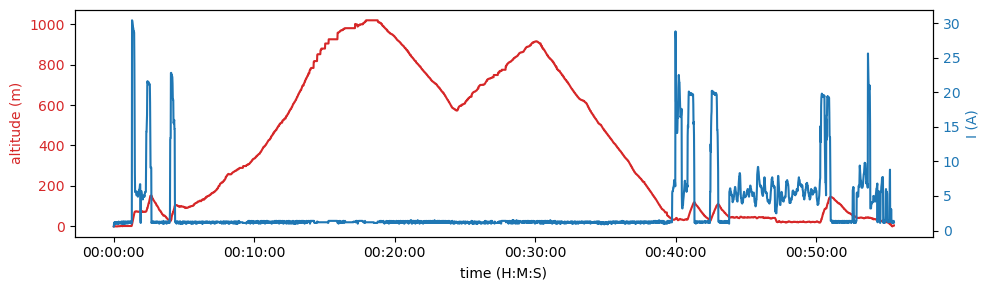

kml file saved


In [37]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import csv
from datetime import datetime
from datetime import date, timedelta
import geopy.distance
from scipy.signal import sosfiltfilt, butter
import matplotlib.dates as mdates
import requests


folder = "D:\\FPV-Video\\20240519-Bojc-2h\\"
file = folder + "FX-61-2024-05-19-112909.csv"

srtFileName = file + ".srt" # generated srt filename
kmlFileName = file + ".kml" # generated kml filename

export = {#'Date':'', 'Time':'',
          #'GPS':'GPS', 
          'Alt(m)':"alt(m)",
          'Curr(A)':'I(A)', 'GSpd(kmh)':'v(km/h)', 'RxBt(V)':'Bt(V)', 'Capa(mAh)':'Capa(mAh)',
          #'TSNR(dB)':'TSNR(dB)',
           # 'TQly(%)':'TQly(%)', 'TPWR(mW)':'TPWR(mW)','FM':'FM',
          'dist(m)':'dist(m)', #non existing column add specially
          'var(m/s)':'var(m/s)',#non existing column add specially
}

dropFMs=['','!ERR','OK','WAIT'] # Flight mode to drop form start and end

def distance_m(home, coords):
    try:
        home = home.split()
        coords = coords.split()
        #print(home)
        #print(coords)
        return geopy.distance.geodesic(home, coords).m
    except Exception as e:
        print(f"home: {home}, coords: {coords}")
        print(e)
        
def linfunc(x,k,n):
    return k*x+n
    
def vario(alts, n):
    if len(alts) < n:
        return 0
    
    t=range(n)
    a = np.array(alts)[-n:]
    popt, pcov = curve_fit(linfunc, t, a)  
    
    return popt[0]

# return elevation of GPS point, used for absolute elevation
def get_elevation(lat,lon):
    
    url = f"https://api.opentopodata.org/v1/aster30m?locations={lat},{lon}"
    r = requests.get(url)

    data = r.json()
    elevation = data['results'][0]['elevation']
    return elevation

"""
1
00:00:00,000 --> 00:00:00,033
<font size="28">FrameCnt: 1, DiffTime: 33ms
2023-05-07 11:38:34.603
[iso: 100] [shutter: 1/800.0] [fnum: 2.8] [ev: 0] [ct: 6462] [color_md : d_cinelike] [focal_len: 12.60] [latitude: 0.00000] [longitude: 0.00000] [rel_alt: 0.000 abs_alt: 0.000] [sharpness: -2] [denoising: -2] </font>
"""

data = []
with open(file) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    
    for row in csv_reader:
        if line_count ==0:
            colNames = row
            
            print(f'{", ".join(colNames)}')
            
            line_count += 1
        else:
            line_count += 1
            data.append(row)
            
colFM = colNames.index('FM')

####  remove non flying FMs
# remove from start
while data[0][colFM] in dropFMs:
    data.pop(0)
    
# remove from end
while data[-1][colFM] in dropFMs:
    data.pop(-1)

#################################################################################
####   add new columns ############################################################################

#add distance ##################################################################
if 'dist(m)' in export:
    print("Generating distances")
    gpsCol = colNames.index('GPS')
    try:
        for i, d in enumerate(data):
            if i==0:
                #get init coords
                homeGPS = d[gpsCol]
                data[0].append('0')
            else:
                dist = distance_m(homeGPS, d[gpsCol])
                #return f"dist(m):{dist:.0f}"
                data[i].append(f'{dist:.0f}')
        colNames.append('dist(m)')
            
    except Exception as e:
        print(f"Failed to add distance to data:\n{i=}\n{d=}\n\nhome: {home}, coords: {coords}")
        print(e)

        
#add vario ################################################################
if 'var(m/s)' in export:
    print("Generating variometer")
    altCol = colNames.index('Alt(m)')
    #make array
    try:
        alts = np.array([int(d[altCol]) for d in data])
        sos = butter(4, 0.125, output='sos')
        alts_filt = sosfiltfilt(sos, alts)
        
        var = np.gradient(alts_filt)
        
        for i, d in enumerate(data):
            d.append(f'{var[i]:.1f}')
        colNames.append('var(m/s)')
        
        """
        plt.plot(alts)
        plt.plot(alts_filt)
        plt.plot(var)
        plt.show()
        
        plt.plot(var)
        plt.show()
        """
    except Exception as e:
        print(f"Failed to add vario to data:\n{i=}\n{d=}")
        print(e)
        
#### make srt #########################################################################################################
print("Generating SRT file")
t=[]
try:
    in_time_format =  '%Y-%m-%d %H:%M:%S.%f'
    srtFP = open(srtFileName,"w")
    dateCol = colNames.index("Date")
    timeCol = colNames.index("Time")
    dtString = data[0][dateCol]+" "+ data[0][timeCol]+"000" # the %f is microseconds
    dt0 = datetime.strptime(dtString, in_time_format)
    dt_start = datetime.fromtimestamp(0) + timedelta(hours=-1)
   
    
    for i, d in enumerate(data):
        srt=f'{i}\n' # row index in srt file
        dtStringFrom = d[dateCol]+" " +d[timeCol] + "000"
        timestamp = datetime.strptime(dtStringFrom, in_time_format) - dt0 + dt_start 
        t.append(timestamp) # use for plot

        #print(timestamp)
        timestamp_str = timestamp.strftime('%H:%M:%S,%f')
        #print(timestamp)
        try:
            dtStringTo = data[i+1][dateCol]+ " " +data[i+1][timeCol] + "000"
            timestampTO_str = (datetime.strptime(dtStringTo, in_time_format) - dt0+ dt_start ).strftime('%H:%M:%S,%f')
        except:
            timestampTO_str = (timestamp + timedelta(seconds=1) ).strftime('%H:%M:%S,%f')
        #print(dtStringTo)
            
       

      
        srt += f'{timestamp_str[:-3]} --> {timestampTO_str[:-3]}' + "\n"
        out=[]
        for col in export:
            index = colNames.index(col)
            #print(f'{i} {index} {col}')
            out.append( f'{export[col]}:{d[index]}' )
        srt += " ".join(out) + "\n\n"

        srtFP.write(srt)
    srtFP.close()
except Exception as e:
    print(f"Failed to write SRT file: {srtFileName}")
    print(e)
    
#### make altitude plot ######################################################################################
print("Make altitude plot and save fig")

tt = t #[datetime.strptime(x, "%H:%M:%S,000") for x in t]
alnp = np.array([float(a) for a in alts])
currCol = colNames.index("Curr(A)")
curr = np.array([float(d[currCol]) for d in data])

#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.rcParams["figure.figsize"] = (10,3)
fig, ax1 = plt.subplots()
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S')) 


color = 'tab:red'
ax1.set_xlabel("time (H:M:S)")
ax1.set_ylabel('altitude (m)', color=color)
ax1.plot(tt, alnp, color=color)
ax1.tick_params(axis='y', labelcolor=color)


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
#ax2.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M:%S')) 


color = 'tab:blue'
ax2.set_ylabel('I (A)', color=color)  # we already handled the x-label with ax1
ax2.plot(tt, curr, color=color)
ax2.tick_params(axis='y', labelcolor=color)


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig(file+".png")

plt.show()

#### make kml ##############################

header = '''<?xml version="1.0" encoding="UTF-8"?>
<kml xmlns="http://www.opengis.net/kml/2.2">
  <Document>
    <name>Paths</name>
    <description>Examples of paths. Note that the tessellate tag is by default
      set to 0. If you want to create tessellated lines, they must be authored
      (or edited) directly in KML.</description>
    <Style id="yellowLineGreenPoly">
      <LineStyle>
        <color>7f00ffff</color>
        <width>4</width>
      </LineStyle>
      <PolyStyle>
        <color>7f00ff00</color>
      </PolyStyle>
    </Style>
    '''
        
end = '''
  </Document>
</kml>'''    

def pm_start(i):
    return f'''<Placemark>
      <TimeStamp>
        <when>{t[i].strftime('%Y-%m-%dT%H:%M:%SZ')}</when>
      </TimeStamp>
      <name>Absolute Extruded</name>
      <description>Transparent green wall with yellow outlines</description>
      <styleUrl>#yellowLineGreenPoly</styleUrl>
      <LineString>
        <extrude>1</extrude>
        <tessellate>1</tessellate>
        <altitudeMode>absolute</altitudeMode>
        <coordinates> 
        '''

pm_end = ''' </coordinates>
      </LineString>
    </Placemark>
    '''

lat, lon = homeGPS.split()
home_elevation = get_elevation(lat,lon) #elevation of the Home point

gps_Col = colNames.index('GPS')
alt_Col = colNames.index('Alt(m)')
path_gps = []

for d in data:    
    lon, lat = d[gps_Col].split(" ")
    elevation = str(int( home_elevation + float(d[alt_Col]) ))
    path_gps.append(f"{lat},{lon},{elevation}")
    #path_gps.append(cords[1]+","+cords[0]+","+ str(int(float(row[alt_Col]))+elevation))

path_arr=[]
chunk_size = 10
chunks = [path_gps[i:i + chunk_size+1] for i in range(0, len(path_gps), chunk_size)]

path_arr = [pm_start(i*chunk_size) + " ".join(c) + pm_end for i, c in enumerate(chunks)]

kml = header + " ".join(path_arr) + end

kmlFP = open(kmlFileName,"w")
kmlFP.write(kml)
kmlFP.close()
print("kml file saved")

In [32]:
print(t[200])

1970-01-01 00:01:40


In [13]:
lat, lon = homeGPS.split()
get_elevation(lat,lon)

71.0

In [9]:
import requests

lat, lon = (53.66, 13.84)

def get_elevation(lat,lon):
    
    url = f"https://api.opentopodata.org/v1/aster30m?locations={lat},{lon}"
    r = requests.get(url)

    data = r.json()
    elevation = data['results'][0]['elevation']
    return elevation

get_elevation(lat,lon)


9.0

In [36]:
import geopy.distance

coords_1 = (52.2296756, 21.0122287)
coords_2 = (52.406374, 16.9251681)

print (geopy.distance.geodesic(coords_1, coords_2).km)


279.35290160430094


In [23]:
alnp[5163]

-31952.0

In [3]:
k=0
for a in alnp:
    if a<-1:
        print(f"{k} -> {a}")
    k=k+1

4949 -> -10193.0
4950 -> -10193.0


In [22]:
g="FM"
d = data[g]
print(d.index("RTH"))

387


In [6]:
colNames

['Date',
 'Time',
 'FM',
 'GPS',
 'GSpd(kmh)',
 'Hdg(°)',
 'Alt(m)',
 'Sats',
 'VSpd(m/s)',
 'Ptch(rad)',
 'Roll(rad)',
 'Yaw(rad)',
 'RxBt(V)',
 'Curr(A)',
 'Capa(mAh)',
 'Bat%(%)',
 '1RSS(dB)',
 '2RSS(dB)',
 'RQly(%)',
 'RSNR(dB)',
 'ANT',
 'RFMD',
 'TPWR(mW)',
 'TRSS(dB)',
 'TQly(%)',
 'TSNR(dB)',
 'Rud',
 'Ele',
 'Thr',
 'Ail',
 'S1',
 '6P',
 'S2',
 'EX1',
 'EX2',
 'EX3',
 'EX4',
 'LS',
 'RS',
 'SA',
 'SB',
 'SC',
 'SD',
 'SE',
 'SF',
 'SG',
 'SH',
 'LSW',
 'CH1(us)',
 'CH2(us)',
 'CH3(us)',
 'CH4(us)',
 'CH5(us)',
 'CH6(us)',
 'CH7(us)',
 'CH8(us)',
 'CH9(us)',
 'CH10(us)',
 'CH11(us)',
 'CH12(us)',
 'CH13(us)',
 'CH14(us)',
 'CH15(us)',
 'CH16(us)',
 'CH17(us)',
 'CH18(us)',
 'CH19(us)',
 'CH20(us)',
 'CH21(us)',
 'CH22(us)',
 'CH23(us)',
 'CH24(us)',
 'CH25(us)',
 'CH26(us)',
 'CH27(us)',
 'CH28(us)',
 'CH29(us)',
 'CH30(us)',
 'CH31(us)',
 'CH32(us)',
 'TxBat(V)']